In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from flask import Flask, request, jsonify
import plotly.express as px

In [3]:
# Function for feature engineering
def engineer_features(df):
    # Feature Decomposition
    df['screen_area'] = df['sc_h'] * df['sc_w']
    # Interaction Features
    df['battery_screen_interaction'] = df['battery_power'] * df['screen_area']
    # Derived Features
    df['battery_efficiency'] = df['talk_time'] / df['battery_power']
    # Expert-Defined Features
    df['performance_score'] = df['ram'] * df['n_cores'] / df['battery_power']
    return df

In [4]:
# Function for preprocessing input data
def preprocess_input(data):
    try:
        df = pd.DataFrame(data, index=[0])
        # Remove irrelevant columns not present during training
        df.drop(['id'], axis=1, inplace=True)
        # Feature Engineering
        df = engineer_features(df)
        return df
    except Exception as e:
        print(f"Preprocessing error: {str(e)}")
        raise



In [5]:
# Load and preprocess training data
df = pd.read_csv("C:/Users/ahmednabil/Documents/Downloads/train - train.csv")
df.dropna(inplace=True)
df = engineer_features(df)


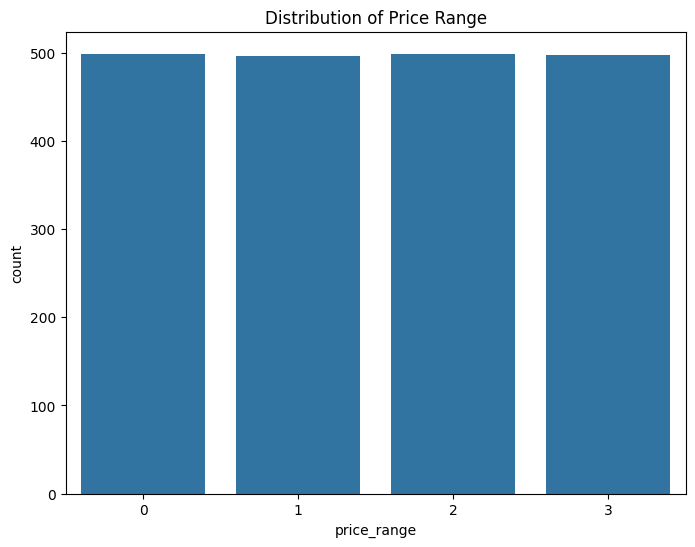

In [6]:
# Count plot for distribution of price range
plt.figure(figsize=(8, 6))
sns.countplot(x='price_range', data=df)
plt.title('Distribution of Price Range')
plt.show()

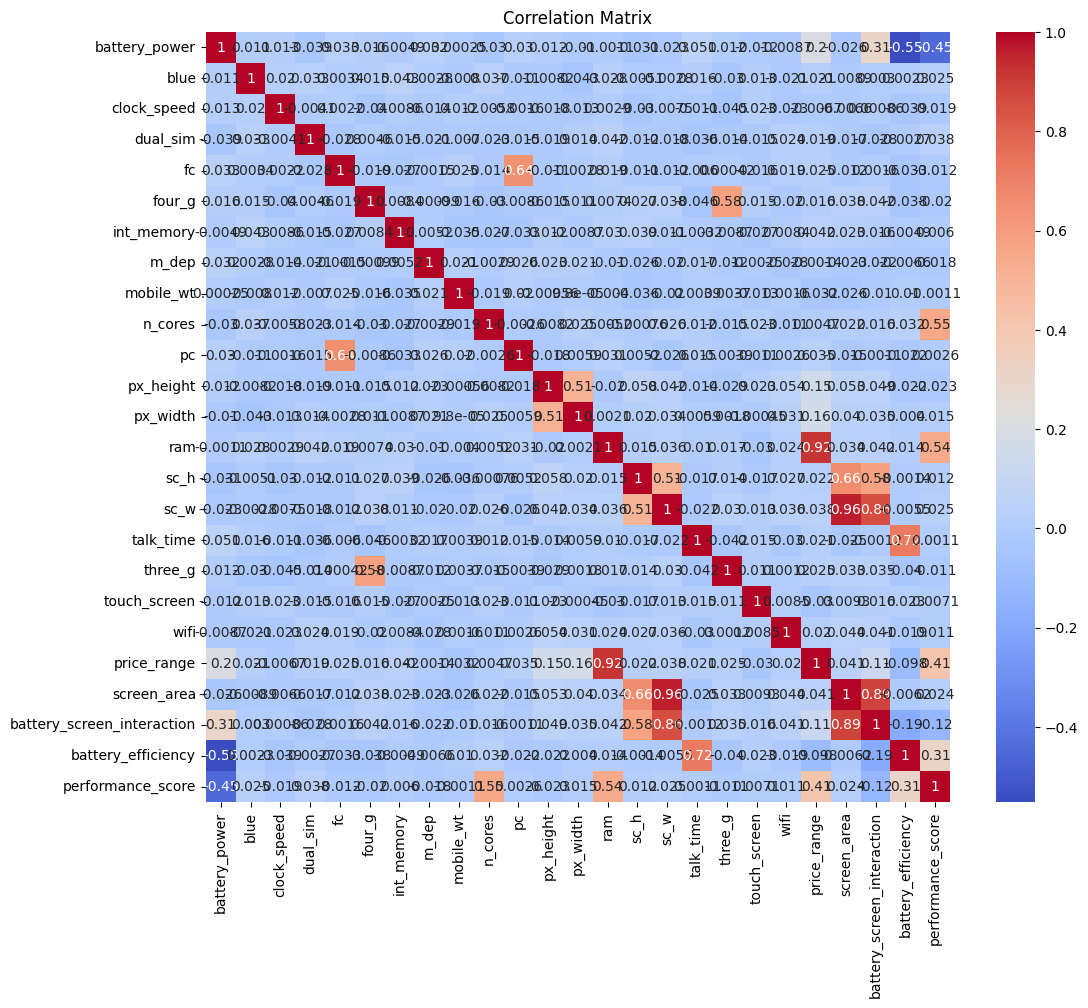

In [7]:
# Heatmap for correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

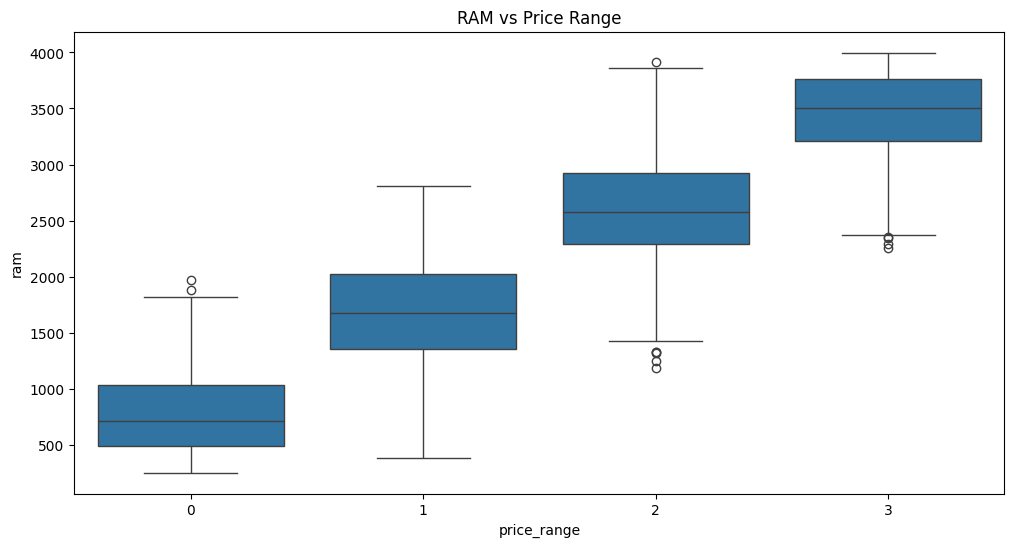

In [8]:
# Boxplot for RAM vs Price Range
plt.figure(figsize=(12, 6))
sns.boxplot(x='price_range', y='ram', data=df)
plt.title('RAM vs Price Range')
plt.show()

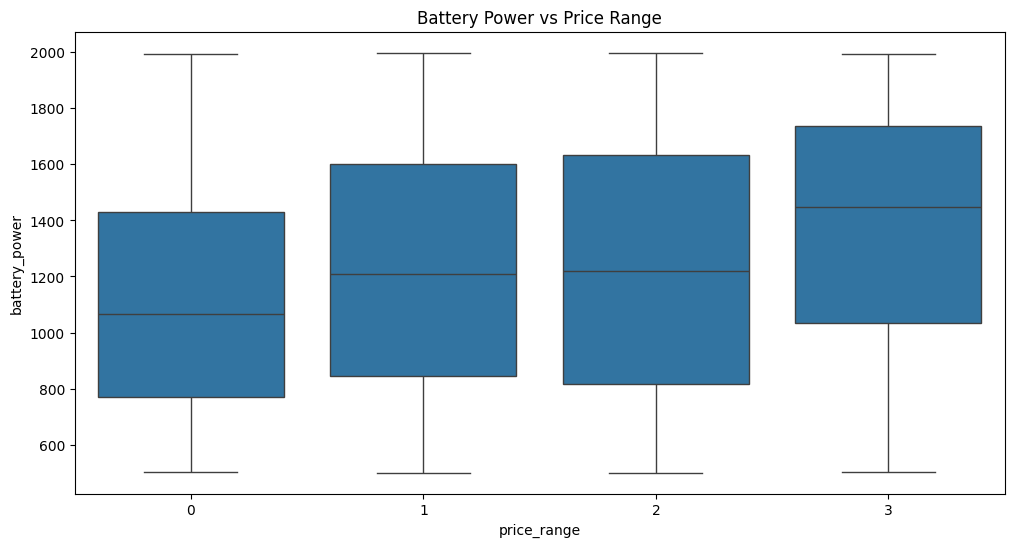

In [9]:
# Boxplot for Battery Power vs Price Range
plt.figure(figsize=(12, 6))
sns.boxplot(x='price_range', y='battery_power', data=df)
plt.title('Battery Power vs Price Range')
plt.show()

In [10]:
# Pie chart for distribution of price range using Plotly Express
price_range_count = df.groupby('price_range').size().reset_index()
price_range_count = price_range_count.rename(columns={0: 'count'})
price_range_count_fig = px.pie(price_range_count, names='price_range', values='count', title='Distribution of Price Range',
                               color_discrete_sequence=px.colors.sequential.RdBu, hole=0.2)
price_range_count_fig.show()


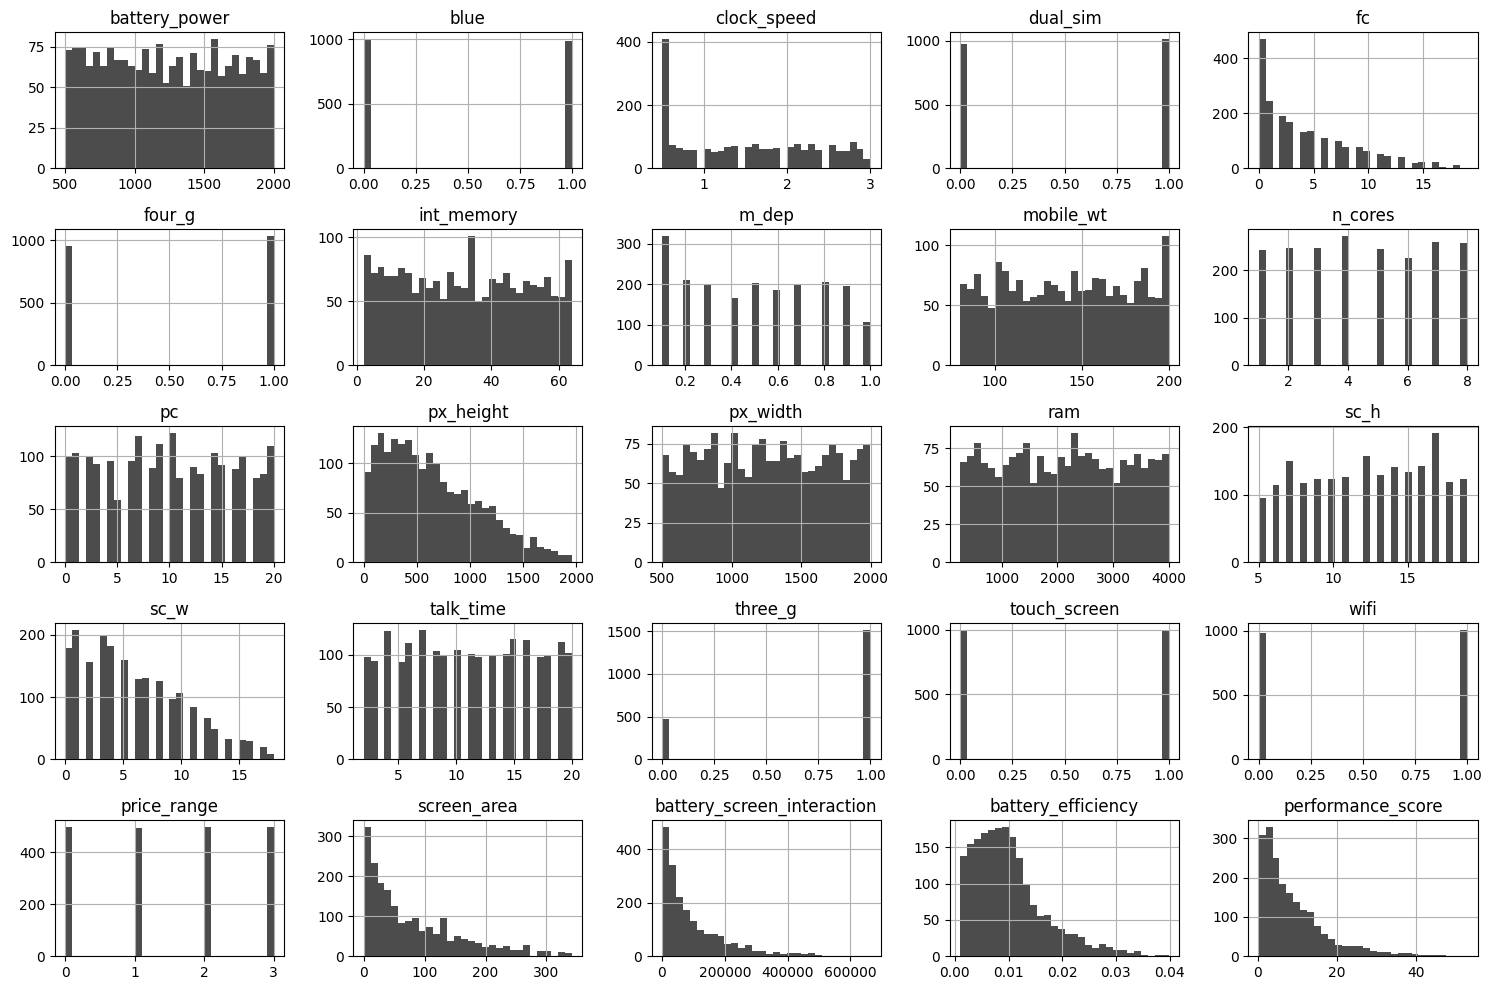

In [11]:
# Histograms for all columns
df.hist(bins=30, color='black', alpha=0.7, figsize=(15, 10))
plt.tight_layout()
plt.show()

In [ ]:
# Model Training
X = df.drop('price_range', axis=1)
y = df['price_range']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_train_scaled, y_train)


In [ ]:
# Evaluation Functions
def evaluate_model(model, X_test, y_test, title):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy ({title}): {accuracy:.5f}")
    print(f"Classification Report ({title}):")
    print(classification_report(y_test, y_pred))
    print(f"Confusion Matrix ({title}):")
    print(confusion_matrix(y_test, y_pred))
    return accuracy

In [ ]:
# Evaluate SVM
svm_accuracy = evaluate_model(svm_classifier, X_test_scaled, y_test, "SVM")

In [ ]:
joblib.dump(svm_classifier, 'svm_model.pkl')
joblib.dump(scaler, 'standard_scaler.pkl')

In [ ]:
# Flask API Setup
app = Flask(__name__)

In [ ]:
# Load models and scaler
svm_model = joblib.load('svm_model.pkl')
scaler = joblib.load('standard_scaler.pkl')

In [ ]:
# Predict function
def predict_price(data):
    try:
        input_data = preprocess_input(data)
        input_data_scaled = scaler.transform(input_data)
        
        svm_pred = svm_model.predict(input_data_scaled)
        return {'svm': svm_pred.tolist()}
    except Exception as e:
        print(f"Prediction error: {str(e)}")
        raise

In [ ]:
@app.route('/predict', methods=['POST'])
def predict():
    try:
        data = request.get_json()
        predicted_prices = predict_price(data)
        return jsonify({'predicted_price': predicted_prices})  
    except Exception as e:
        return jsonify({'error': str(e)}), 400


In [ ]:
if __name__ == '__main__':
    app.run(port=5001)